In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    return precision


def recall_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])
    
    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)
    return recall

In [3]:
data = pd.read_csv('../raw_data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('../raw_data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [9]:
def get_recommendations(user, sparse_user_item, model, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

### ALS

C:\Users\Diana\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.1872673849167458, N = 50
Best recall: 0.031438186772331136, N = 100


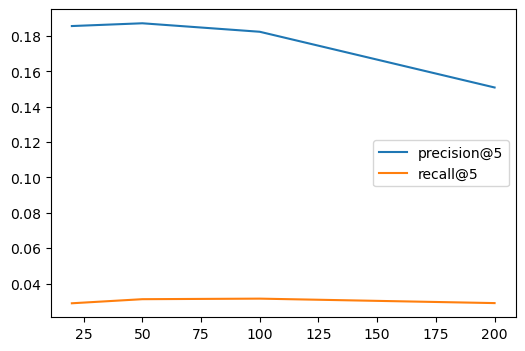

In [10]:
n_range = [20, 50, 100, 200]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=n, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(sparse_user_item,  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.18276199804113372, N = 0.01
Best recall: 0.03185767692631968, N = 0.1


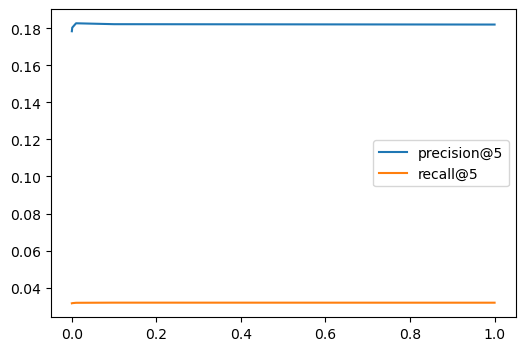

In [11]:
n_range = [1, 0.1, 0.01, 0.001, 0.0001]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=n,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(sparse_user_item,  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Best precision: 0.23672869735553112, N = 1
Best recall: 0.0343200375846828, N = 1


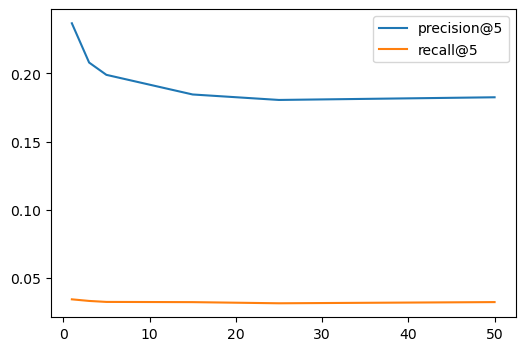

In [12]:
n_range = [1, 3, 5, 15, 25, 50]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.1,
                                    iterations=n, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(sparse_user_item,  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

### BM25

In [13]:
user_item_matrix = bm25_weight(user_item_matrix.T).T

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.23300685602350327, N = 200
Best recall: 0.03763616346618368, N = 200


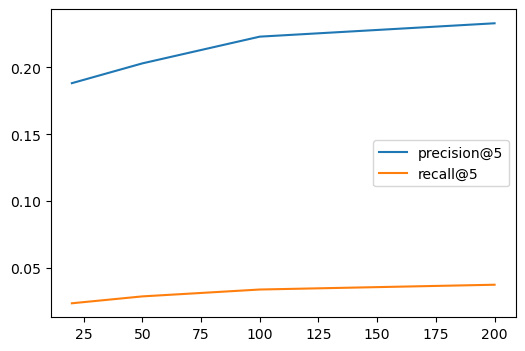

In [14]:
n_range = [20, 50, 100, 200]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=n, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.234769833496569, N = 1
Best recall: 0.039070870735047634, N = 1


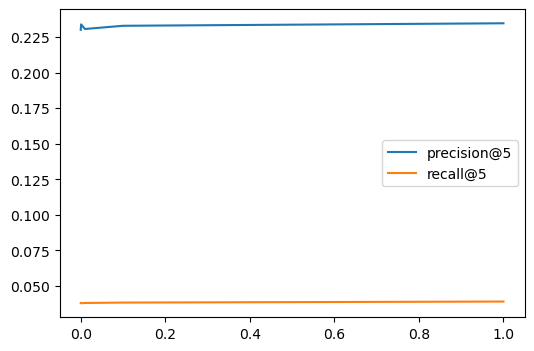

In [16]:
n_range = [1, 0.1, 0.01, 0.001, 0.0001]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=200, 
                                    regularization=n,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Best precision: 0.2225269343780581, N = 25
Best recall: 0.035561185297296224, N = 25


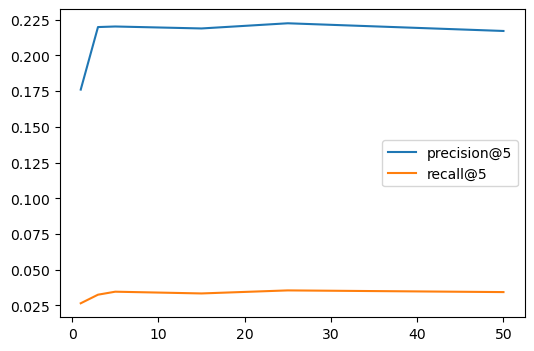

In [17]:
n_range = [1, 3, 5, 15, 25, 50]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=100, 
                                    regularization=1,
                                    iterations=n, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

### TF-IDF

In [18]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [19]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T 

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.19735553379039883, N = 20
Best recall: 0.03232091286670164, N = 200


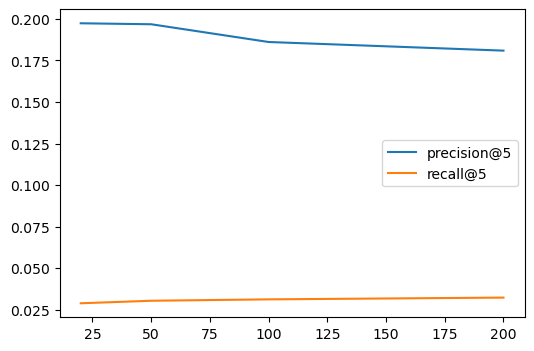

In [25]:
n_range = [20, 50, 100, 200]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=n, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Best precision: 0.18560235063662828, N = 0.1
Best recall: 0.034128959085493335, N = 0.1


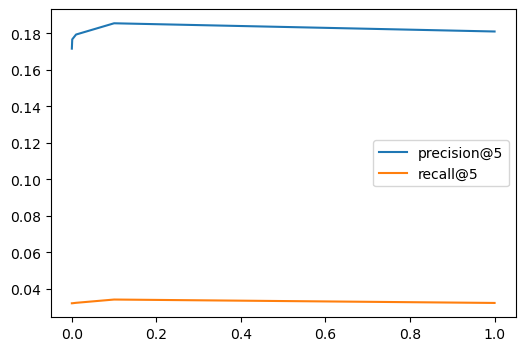

In [21]:
n_range = [1, 0.1, 0.01, 0.001, 0.0001]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=200, 
                                    regularization=n,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Best precision: 0.2227228207639536, N = 1
Best recall: 0.03484732467814309, N = 1


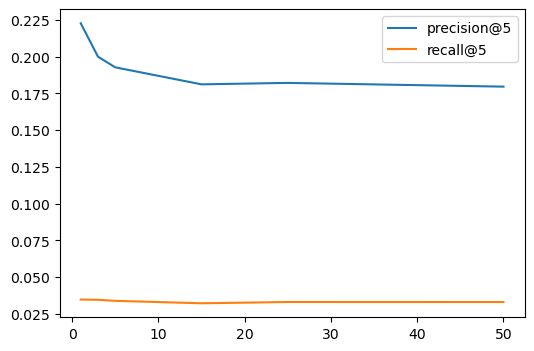

In [23]:
n_range = [1, 3, 5, 15, 25, 50]
precision = []
recall = []

for n in n_range:
    model = AlternatingLeastSquares(factors=200, 
                                    regularization=0.1,
                                    iterations=n, 
                                    calculate_training_loss=True, 
                                    num_threads=4)

    model.fit(csr_matrix(user_item_matrix).tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    result['st'] = result['user_id'].apply(lambda x: get_recommendations(x, 
                                          sparse_user_item=sparse_user_item, model=model, N=5))
    precision.append(result.apply(lambda row: precision_at_k(row['st'], row['actual'], k=5), axis=1).mean())
    recall.append(result.apply(lambda row: recall_at_k(row['st'], row['actual'], k=5), axis=1).mean())

print('Best precision: {}, N = {}'.format(max(precision), n_range[precision.index(max(precision))]))
print('Best recall: {}, N = {}'.format(max(recall), n_range[recall.index(max(recall))]))

plt.figure(figsize=(6, 4))

plt.plot(n_range, precision, label='precision@5')
plt.plot(n_range, recall, label='recall@5')
plt.legend()
plt.show()